In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
%matplotlib inline

In [3]:
nc_file = 'NOAA_Daily_phi_500mb.nc'
file = Dataset(nc_file, mode='r')

In [4]:
lons = file.variables['X'][:]
lats = file.variables['Y'][:]
pressure = file.variables['P'][:]
time = file.variables['T'][:]
height = file.variables['phi'][:]

In [5]:
file.close()

In [9]:
# 24873 days, 15 by 144 degrees = 2160
data = height.reshape(24873, 2160).astype(np.float64)

In [10]:
data

array([[ 5181.,  5180.,  5178., ...,  5726.,  5728.,  5727.],
       [ 5132.,  5140.,  5146., ...,  5784.,  5787.,  5783.],
       [ 5102.,  5104.,  5106., ...,  5779.,  5785.,  5784.],
       ..., 
       [ 5138.,  5119.,  5100., ...,  5816.,  5811.,  5806.],
       [ 5216.,  5200.,  5181., ...,  5796.,  5798.,  5796.],
       [ 5227.,  5225.,  5221., ...,  5747.,  5760.,  5771.]])

In [11]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
# Center to the mean and component wise scale to unit variance.
scaled_data = scale(data)

In [14]:
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=10)
pca.fit(scaled_data)

# transform
data_reduced = np.dot(scaled_data, pca.components_.T)
# inverse_transform
data_original = np.dot(data_reduced, pca.components_)

In [15]:
pca.explained_variance_ratio_

array([ 0.58604277,  0.03506168,  0.03039151,  0.0290161 ,  0.0254986 ,
        0.02398376,  0.02175764,  0.01875261,  0.01660459,  0.01550454])

In [19]:
n_components = len(pca.explained_variance_ratio_)
total_variance = sum(pca.explained_variance_ratio_)
print("The first {0} components explain {1}% of the variance".format(n_components, total_variance * 100))

The first 10 components explain 80.26138132810007% of the variance


In [20]:
# These are eigenvectors!
pca.components_

array([[ 0.01888119,  0.01893315,  0.01901356, ...,  0.01960814,
         0.0203964 ,  0.0211537 ],
       [-0.01105288, -0.00646948, -0.00215948, ...,  0.02432222,
         0.02196218,  0.01973821],
       [ 0.0376445 ,  0.03680992,  0.03559918, ..., -0.01922621,
        -0.01744398, -0.01556139],
       ..., 
       [ 0.00600917,  0.0069393 ,  0.00764963, ...,  0.02080918,
         0.02171215,  0.02170775],
       [-0.00644299, -0.00571115, -0.00503432, ...,  0.02181851,
         0.02049969,  0.01846065],
       [ 0.01344142,  0.01216508,  0.01079277, ..., -0.00588136,
        -0.00413251, -0.00253731]])

In [21]:
# Each day has been reduced to have only 10 values
data_reduced.shape

(24873, 10)

In [28]:
# recover the original shape of the data
recovered_data = data_original.reshape(24873, 1, 15, 144)

In [30]:
# for example, this is January 1, 1948 as reconstructed by the 10 principal components
recovered_data[0, 0].shape

(15, 144)

In [31]:
# Let's plot some stuff
m = Basemap(projection='robin', lat_0=0, lon_0=-100,
              resolution='l', area_thresh=1000.0)

# Because our lon and lat variables are 1D, 
# use meshgrid to create 2D arrays 
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

In [46]:
def plot_day(data, day):
    """
    Creates a plot of the world with colorcoded data
    """
    plt.figure(figsize=(15,12))
    # Plot Data
    cs = m.pcolor(xi,yi,data[day, 0])

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # Shaded relief adds the nice global color
    m.shadedrelief()

    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")

    # Add Title
    plt.title("Reconstructed Geopotential Height {} Days Since 1-1-1948".format(day))

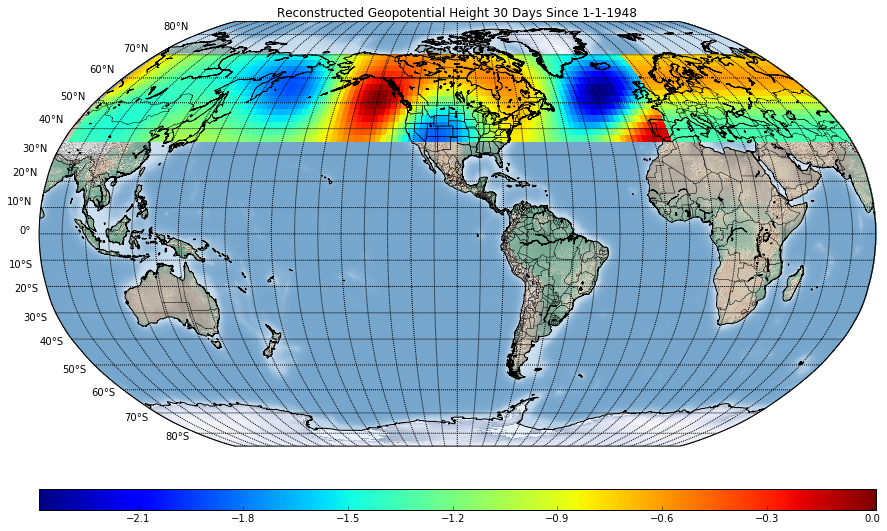

In [47]:
# This can be slow the first time you all it
plot_day(recovered_data, 30)